In [938]:
# Insira sua resposta aqui
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
sns.set()
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn import linear_model
import sklearn.metrics as metrics
from scipy.stats import zscore
from sklearn.svm import SVR, LinearSVR,NuSVR
from sklearn.naive_bayes import GaussianNB
sns.set()

In [939]:
comp_price = pd.read_csv('test_prc/comp_prices.csv', sep=',')
sales = pd.read_csv('test_prc/sales.csv', sep=',')

# B2W Challange

The sales.csv file contains transactional information where each line represents a sale. The comp_prices.csv file contains monitoring data of competitors’ prices. We have data available for 6 competitors, C1 to C6, which are monitored twice per day. The information below describes the data in each column:

- **PROD_ID**: Product ID. We provide data for 9 different products, P1 to P9;
- **DATE_ORDER**: Sales Date, under YYYY-MM-DD format;
- **QTY_ORDER*: Quantity Sold;
- **REVENUE**: Sale revenue. There can be variations of the price for the same product, depending on the sales channel or discounts, which are applied to the base price;
- **DATE_EXTRACTION**: Date and Time of the extraction of the competitors’ price, under YYYY-MM-DD HH:MM:SS format;
- **COMPETITOR**: Competitors’ ID (C1 to C6);
- **COMPETITOR_PRICE**: Competitors’ price per product, which can depend on the payment method;
- **PAY_TYPE**: Payment Method (1=deferred payment, 2=immediate payment).

1) Models for Demand Forecasting: The main objective is to create a model to predict the quantity sold for each product given a prescribed price. Along with the statistical model, we need metrics, relationships and descriptions of these data in order to understand the sales behavior. What does the data tell us? How are the different data sources related? Is there a particular competitor that seems more important?

2) Presentation of the results: we want to know what were the steps and your strategy (approach to the problem) during the analysis, even if these may seem wrong. The process you went through and the reasoning behind it, is as important as the solutions you found. For this, please prepare a clear and objective presentation to explain both your methodology and your results. In case you are selected for the interview, you will need to make a 20-minute (max) presentation.

In [940]:
sales['DATE_ORDER'] = pd.to_datetime(sales['DATE_ORDER'])
comp_price['DATE_EXTRACTION_DAY'] = pd.to_datetime(comp_price['DATE_EXTRACTION'].str.split(' ').str[0]) #compare extration by day
comp_price['DATE_EXTRACTION'] = pd.to_datetime(comp_price['DATE_EXTRACTION'])

# Data Preparation / Exploratory Analysis

Dado o objetivo do problema prescrito (quantidade vendida de cada produto dado um preço) entende-se que a métrica COMPETITOR_PRICE é de grande relevância para a previsão e a mesma será utilizada como feature do modelo. Para isso será necessária a criação da relação dos dados por dia e produto.

In [941]:
sales_agg = sales.groupby(['PROD_ID','DATE_ORDER']).agg({'QTY_ORDER': ['sum'], 'REVENUE': ['min']}).reset_index()
sales_agg.columns = sales_agg.columns.get_level_values(0)
sales_agg

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P1,2015-02-04,10.0,1499.00
1,P1,2015-02-05,12.0,1349.10
2,P1,2015-02-06,21.0,1349.10
3,P1,2015-02-07,4.0,1499.00
4,P1,2015-02-08,7.0,1499.00
...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89
2158,P9,2015-10-11,87.0,388.66
2159,P9,2015-10-12,110.0,388.63
2160,P9,2015-10-13,328.0,341.10


In [942]:
comp_dummies = pd.get_dummies(data=comp_price, columns=['COMPETITOR', 'PAY_TYPE'])

columns = ['PROD_ID',
            'DATE_EXTRACTION_DAY', 
            'COMPETITOR_C1', 
            'COMPETITOR_C2', 
            'COMPETITOR_C3', 
            'COMPETITOR_C4', 
            'COMPETITOR_C5', 
            'COMPETITOR_C6', 
            'PAY_TYPE_1', 
            'PAY_TYPE_2']

comp_price_agg = comp_dummies.groupby(columns).agg({'COMPETITOR_PRICE': ['min']}).reset_index()
comp_price_agg.columns = comp_price_agg.columns.get_level_values(0)
comp_price_agg

,PROD_ID,DATE_EXTRACTION_DAY,COMPETITOR_C1,COMPETITOR_C2,COMPETITOR_C3,COMPETITOR_C4,COMPETITOR_C5,COMPETITOR_C6,PAY_TYPE_1,PAY_TYPE_2,COMPETITOR_PRICE
0,P1,2015-03-15,0,0,0,0,0,1,0,1,1499.00
1,P1,2015-03-15,0,0,0,0,0,1,1,0,1499.00
2,P1,2015-03-15,0,0,0,0,1,0,0,1,1499.00
3,P1,2015-03-15,0,0,0,0,1,0,1,0,1499.00
4,P1,2015-03-16,0,0,0,0,0,1,0,1,1499.00
...,...,...,...,...,...,...,...,...,...,...,...
17315,P9,2015-10-14,0,0,1,0,0,0,1,0,393.00
17316,P9,2015-10-14,0,1,0,0,0,0,0,1,393.96
17317,P9,2015-10-14,0,1,0,0,0,0,1,0,393.96
17318,P9,2015-10-14,1,0,0,0,0,0,0,1,393.00


In [943]:
comp_price_agg_min_f = comp_price_agg.groupby(['PROD_ID','DATE_EXTRACTION_DAY']).agg({'COMPETITOR_PRICE': 'last'}).reset_index()
comp_price_agg_min_f

,PROD_ID,DATE_EXTRACTION_DAY,COMPETITOR_PRICE
0,P1,2015-03-15,1499.00
1,P1,2015-03-16,1362.50
2,P1,2015-03-17,1362.50
3,P1,2015-03-18,1362.50
4,P1,2015-03-19,1499.00
...,...,...,...
1927,P9,2015-10-10,395.82
1928,P9,2015-10-11,395.82
1929,P9,2015-10-12,395.76
1930,P9,2015-10-13,393.00


In [944]:
df = pd.DataFrame.merge(sales_agg, comp_price_agg_min_f, how='left', left_on=['PROD_ID','DATE_ORDER'], right_on = ['PROD_ID','DATE_EXTRACTION_DAY']).drop(['DATE_EXTRACTION_DAY'], axis=1)
df

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,COMPETITOR_PRICE
0,P1,2015-02-04,10.0,1499.00,NaN
1,P1,2015-02-05,12.0,1349.10,NaN
2,P1,2015-02-06,21.0,1349.10,NaN
3,P1,2015-02-07,4.0,1499.00,NaN
4,P1,2015-02-08,7.0,1499.00,NaN
...,...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89,395.82
2158,P9,2015-10-11,87.0,388.66,395.82
2159,P9,2015-10-12,110.0,388.63,395.76
2160,P9,2015-10-13,328.0,341.10,393.00


# Remoção de outliers

O tratamento dos outliers foram executados por itens e tratados nos valores com base no desvio padrão acima de 3. Para o COMPETITOR_PRICE os outliers foram substituidos pelo mesmo valor de REVENUE correspondente, os demais receberam a média por produto. 

In [945]:
base = 'PROD_ID'

for b in df[base].unique():
    n = df["REVENUE"].loc[df[base] == b]
    n,m = n[np.abs(zscore(n)) > 3].index, 'REVENUE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].loc[df[base] == b].mean()

    n = df["QTY_ORDER"].loc[df[base] == b]
    n,m = n[np.abs(zscore(n)) > 3].index, 'QTY_ORDER'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['QTY_ORDER'].loc[df[base] == b].mean()
    
    n,m = df['COMPETITOR_PRICE'].loc[(np.isnan(df['COMPETITOR_PRICE'])) & (df[base] == b)].index, 'COMPETITOR_PRICE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].iloc[int(i)]

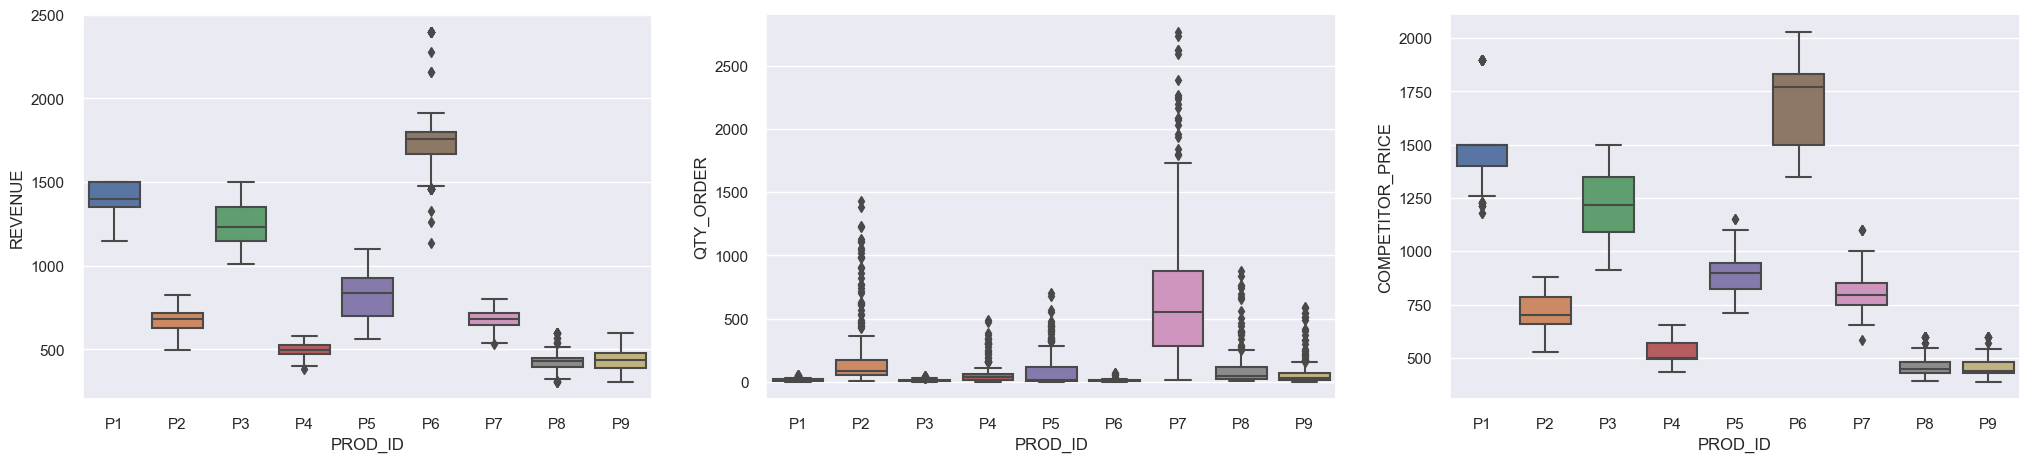

In [946]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

sns.boxplot(data=df, x='PROD_ID', y='REVENUE', ax=ax[0])
ax[0].set_title("Boxplot Revenue vs PROD")
sns.boxplot(data=df, x='PROD_ID', y='QTY_ORDER', ax=ax[1])
ax[1].set_title("Boxplot Qty Order vs PROD")
sns.boxplot(data=df, x='PROD_ID', y='COMPETITOR_PRICE', ax=ax[2])
plt.show()

# Transform to supervised

Decidi optar pela utilização de modelos supervisionados para a solução do problema afim de obter mais possibilidades de parametrização e diversidade de modelos. Para isso efetuei a transformação do meu problema para um ambiente supervisionado. 

Podemos usar a função shift () no Pandas para criar automaticamente novos enquadramentos de problemas de série temporal, dado o comprimento desejado das sequências de entrada e saída.

Essa seria uma ferramenta útil, pois nos permitiria explorar diferentes enquadramentos de um problema de série temporal com algoritmos de aprendizado de máquina para ver o que poderia resultar em modelos de melhor desempenho.

In [947]:
def transform_to_supervised(df,
                            previous_steps=1, 
                            forecast_steps=1,
                            dropnan=True):
    
    # original column names
    col_names = df.columns
    print(col_names)
    
    # list of columns and corresponding names we'll build from 
    # the originals found in the input DataFrame
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(previous_steps, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for col_name in col_names]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecast_steps):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % col_name) for col_name in col_names]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for col_name in col_names]

    # put all the columns together into a single aggregated DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [948]:
base = 'PROD_ID'
columns = ['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE']
df_transformed = pd.DataFrame()

for b in df[base].unique():

    dft = transform_to_supervised(df[columns].loc[df[base] == b], previous_steps=2, forecast_steps=3)
    dft[base] = b
    df_transformed = df_transformed.append(dft, ignore_index=True,sort=False)

df_transformed

Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')


,QTY_ORDER(t-2),REVENUE(t-2),COMPETITOR_PRICE(t-2),QTY_ORDER(t-1),REVENUE(t-1),COMPETITOR_PRICE(t-1),QTY_ORDER(t),REVENUE(t),COMPETITOR_PRICE(t),QTY_ORDER(t+1),REVENUE(t+1),COMPETITOR_PRICE(t+1),QTY_ORDER(t+2),REVENUE(t+2),COMPETITOR_PRICE(t+2),PROD_ID
0,10.0,1499.00,1499.00,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,P1
1,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,P1
2,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,P1
3,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,P1
4,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,16.0,1259.10,1259.10,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,50.0,359.10,414.00,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,P9
2122,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,P9
2123,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,P9
2124,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,328.0,341.10,393.00,P9


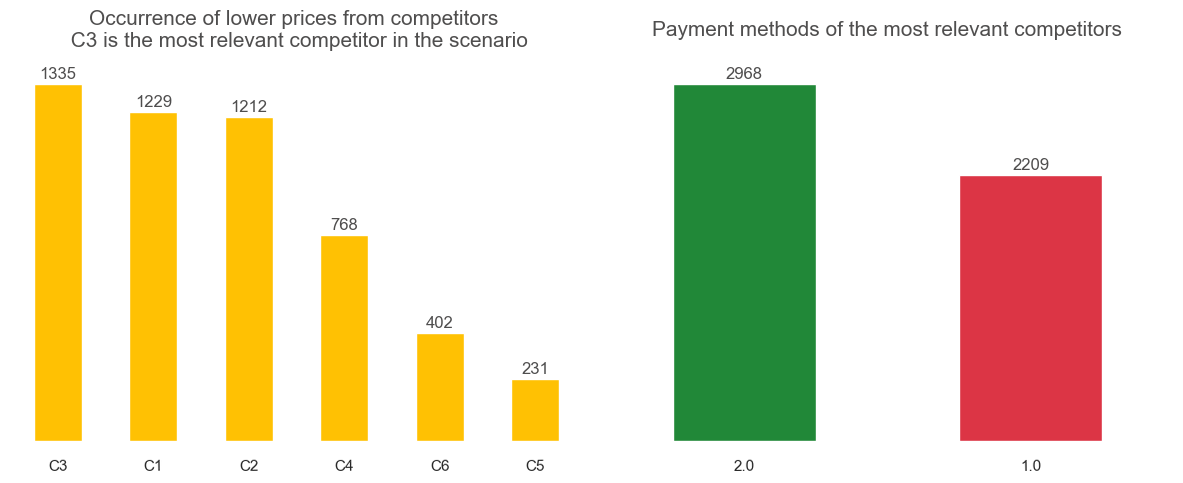

In [949]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

comp_price_agg2 = comp_price.groupby(['PROD_ID', 'DATE_EXTRACTION_DAY', 'PAY_TYPE', 'COMPETITOR']).agg({'COMPETITOR_PRICE': ['min']}).reset_index()
comp_price_agg2.columns = comp_price_agg2.columns.get_level_values(0)
competitor_compare = pd.DataFrame.merge(sales_agg, comp_price_agg2, 
                                how='left', 
                                left_on=['PROD_ID','DATE_ORDER'], 
                                right_on = ['PROD_ID','DATE_EXTRACTION_DAY']).drop(['DATE_EXTRACTION_DAY'], axis=1,)
competitor_compare['COMPETITOR'].loc[competitor_compare['REVENUE'] > competitor_compare['COMPETITOR_PRICE']].value_counts(sort=True).plot.bar(rot=1, ax=ax[0], color='#ffc103')
competitor_compare['PAY_TYPE'].loc[competitor_compare['REVENUE'] > competitor_compare['COMPETITOR_PRICE']].value_counts(sort=True).plot.bar(rot=1, ax=ax[1], color=['#218838','#dc3545' ])

ax[0].get_yaxis().set_ticks([])
ax[0].grid(False)
ax[0].set(frame_on=False) 
ax[0].set_title("Occurrence of lower prices from competitors \n C3 is the most relevant competitor in the scenario", fontsize=15, color='#4f4e4e', y=1.03)
ax[0].bar_label(ax[0].containers[0], padding=2, fontsize=12, color='#4f4e4e')

ax[1].get_yaxis().set_ticks([])
ax[1].grid(False)
ax[1].set(frame_on=False) 
ax[1].set_title("Payment methods of the most relevant competitors", fontsize=15, color='#4f4e4e', y=1.06)
ax[1].bar_label(ax[1].containers[0], padding=2, fontsize=12, color='#4f4e4e')

fig.tight_layout()
plt.show()

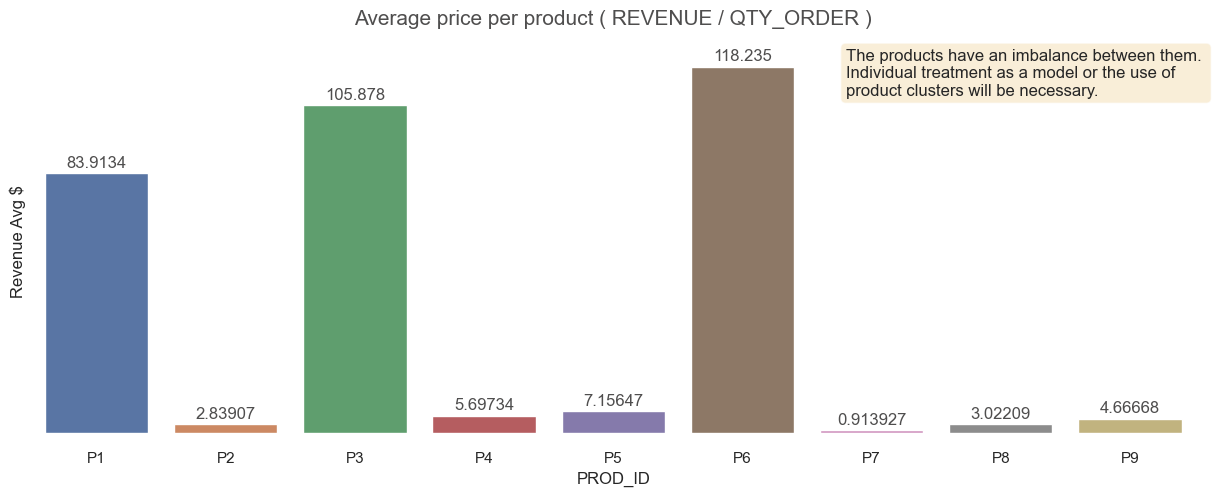

In [950]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

sales_agg2 = sales_agg.groupby(['PROD_ID']).agg({'QTY_ORDER': ['sum'], 'REVENUE': ['sum']}).reset_index()
sales_agg2.columns = sales_agg2.columns.get_level_values(0)
sales_agg2['Revenue Avg $'] = sales_agg2['REVENUE'] / sales_agg2['QTY_ORDER'] 
# sales_agg2
# sales_agg2['Revenue Avg $'].plot.bar()
# plt.show()
sns.barplot(data=sales_agg2, y='Revenue Avg $', x='PROD_ID', ax=ax)

ax.get_yaxis().set_ticks([])
ax.grid(False)
ax.set(frame_on=False) 
ax.set_title("Average price per product ( REVENUE / QTY_ORDER )", fontsize=15, color='#4f4e4e', y=1.04)
ax.bar_label(ax.containers[0], padding=2, fontsize=12, color='#4f4e4e')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.7, 1, 'The products have an imbalance between them. \nIndividual treatment as a model or the use of\nproduct clusters will be necessary.', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

plt.show()

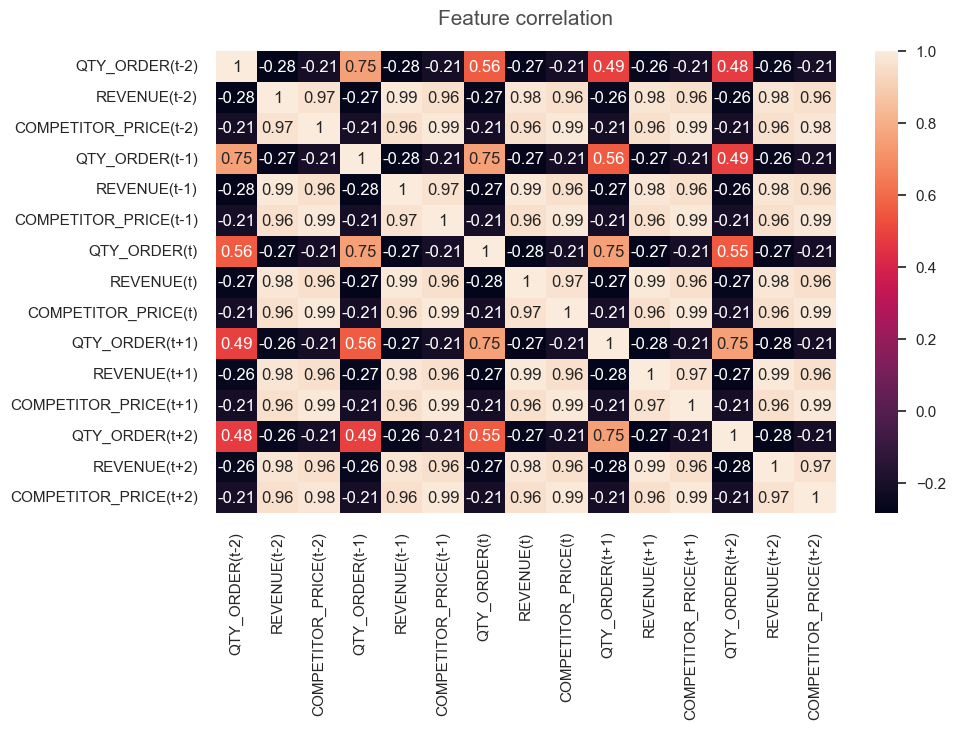

In [951]:
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_transformed.corr(), ax=ax, annot=True)

ax.set_title("Feature correlation", fontsize=15, color='#4f4e4e', y=1.04)
# ax.bar_label(ax.containers[0], padding=2, fontsize=12, color='#4f4e4e')

plt.show()

# Criação de Features

In [952]:
X = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"])
y = df_transformed["QTY_ORDER(t)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## Train and test by Produts

In [953]:
base = 'PROD_ID'

X_trainp, X_testp, y_trainp, y_testp = [], [], [], []
prod_mapping = {}
c=0
for b in df[base].unique():
    Xp = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"]).loc[df_transformed[base] == b]
    yp = df_transformed["QTY_ORDER(t)"].loc[df_transformed[base] == b]
    
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xp, yp, test_size=.2)
    
    X_trainp.append(X_train_t)
    X_testp.append(X_test_t)
    y_trainp.append(y_train_t)
    y_testp.append(y_test_t)

    prod_mapping[c] = b
    c+=1

## K-means

In [954]:
df_clust = df.groupby(['PROD_ID']).agg({'QTY_ORDER': ['sum'], 'REVENUE': ['sum']}).reset_index()
df_clust.columns = df_clust.columns.get_level_values(0)
df_clust_prodid = df_clust["PROD_ID"]
df_clust = df_clust.drop(columns=["PROD_ID"])

scaler = MinMaxScaler()
scaler.fit(df_clust)
scaled_df = scaler.transform(df_clust)
scaled_df = pd.DataFrame(scaled_df, columns=df_clust.columns)

df_clust

,QTY_ORDER,REVENUE
0,3929.719740,350170.510000
1,53647.024112,192613.600000
2,2739.879920,312235.060000
3,13244.636182,99144.201190
4,17077.011080,149408.145137
5,2723.437701,497913.247133
6,196459.922203,193632.176743
7,23218.193662,90318.957238
8,15231.237397,91751.650000


C:\Users\erycm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters= 1, inertia=1.7647201645203625
n_clusters= 2, inertia=0.8752308223661127
n_clusters= 3, inertia=0.1947110740304068
n_clusters= 4, inertia=0.08317788494418162
n_clusters= 5, inertia=0.02009640377282123
n_clusters= 6, inertia=0.006105029976990906
n_clusters= 7, inertia=0.0017550099934527464


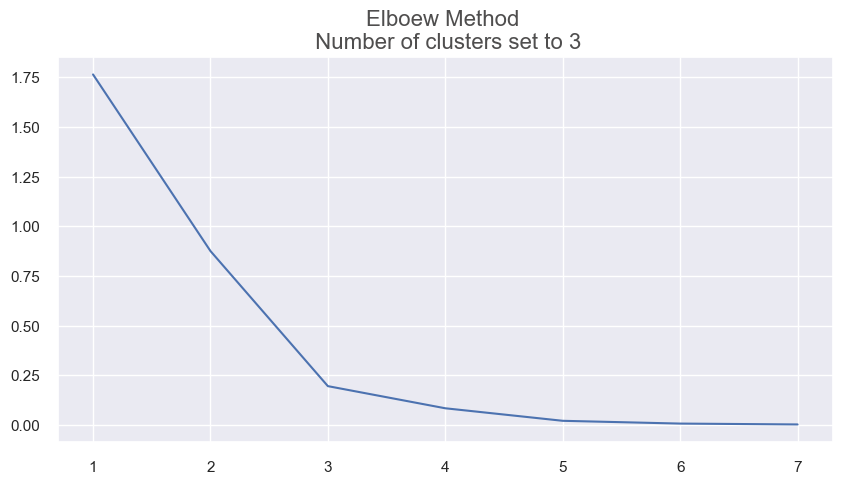

In [955]:
inertias = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)
    print(f"n_clusters= {i}, inertia={kmeans.inertia_}")


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.lineplot(y=inertias, x=range(1,8), ax=axes)
axes.set_title("Elboew Method \n Number of clusters set to 3", fontsize=16, color='#4f4e4e')
plt.show()

In [956]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df)
cluster_label = kmeans.predict(scaled_df)
df_clust["LABEL"] = cluster_label
df_clust = pd.concat([df_clust_prodid, df_clust], axis=1)

label = [] 
for prod in df_transformed['PROD_ID'].values:
    label.append(int(df_clust['LABEL'].loc[df_clust['PROD_ID'] == prod].values[0]))
df_transformed['LABEL'] = label

df_clust

,PROD_ID,QTY_ORDER,REVENUE,LABEL
0,P1,3929.719740,350170.510000,1
1,P2,53647.024112,192613.600000,0
2,P3,2739.879920,312235.060000,1
3,P4,13244.636182,99144.201190,0
4,P5,17077.011080,149408.145137,0
5,P6,2723.437701,497913.247133,1
6,P7,196459.922203,193632.176743,2
7,P8,23218.193662,90318.957238,0
8,P9,15231.237397,91751.650000,0


In [957]:
df_clust.groupby(["LABEL"]).count()

,PROD_ID,QTY_ORDER,REVENUE
LABEL,,,
0,5,5,5
1,3,3,3
2,1,1,1


In [958]:
base = 'LABEL'

X_traincls, X_testcls, y_traincls, y_testcls = [], [], [], []
cluster_mapping = {}
c=0
for b in df_transformed[base].unique():
    Xcls = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID", 'LABEL']).loc[df_transformed[base] == b]
    ycls = df_transformed["QTY_ORDER(t)"].loc[df_transformed[base] == b]
    
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(Xcls, ycls, test_size=.2)

    X_traincls.append(X_train_cls)
    X_testcls.append(X_test_cls)
    y_traincls.append(y_train_cls)
    y_testcls.append(y_test_cls)

    cluster_mapping[c] = b
    c+=1

In [959]:
df_transformed

,QTY_ORDER(t-2),REVENUE(t-2),COMPETITOR_PRICE(t-2),QTY_ORDER(t-1),REVENUE(t-1),COMPETITOR_PRICE(t-1),QTY_ORDER(t),REVENUE(t),COMPETITOR_PRICE(t),QTY_ORDER(t+1),REVENUE(t+1),COMPETITOR_PRICE(t+1),QTY_ORDER(t+2),REVENUE(t+2),COMPETITOR_PRICE(t+2),PROD_ID,LABEL
0,10.0,1499.00,1499.00,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,P1,1
1,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,P1,1
2,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,P1,1
3,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,P1,1
4,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,16.0,1259.10,1259.10,P1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,50.0,359.10,414.00,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,P9,0
2122,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,P9,0
2123,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,P9,0
2124,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,328.0,341.10,393.00,P9,0


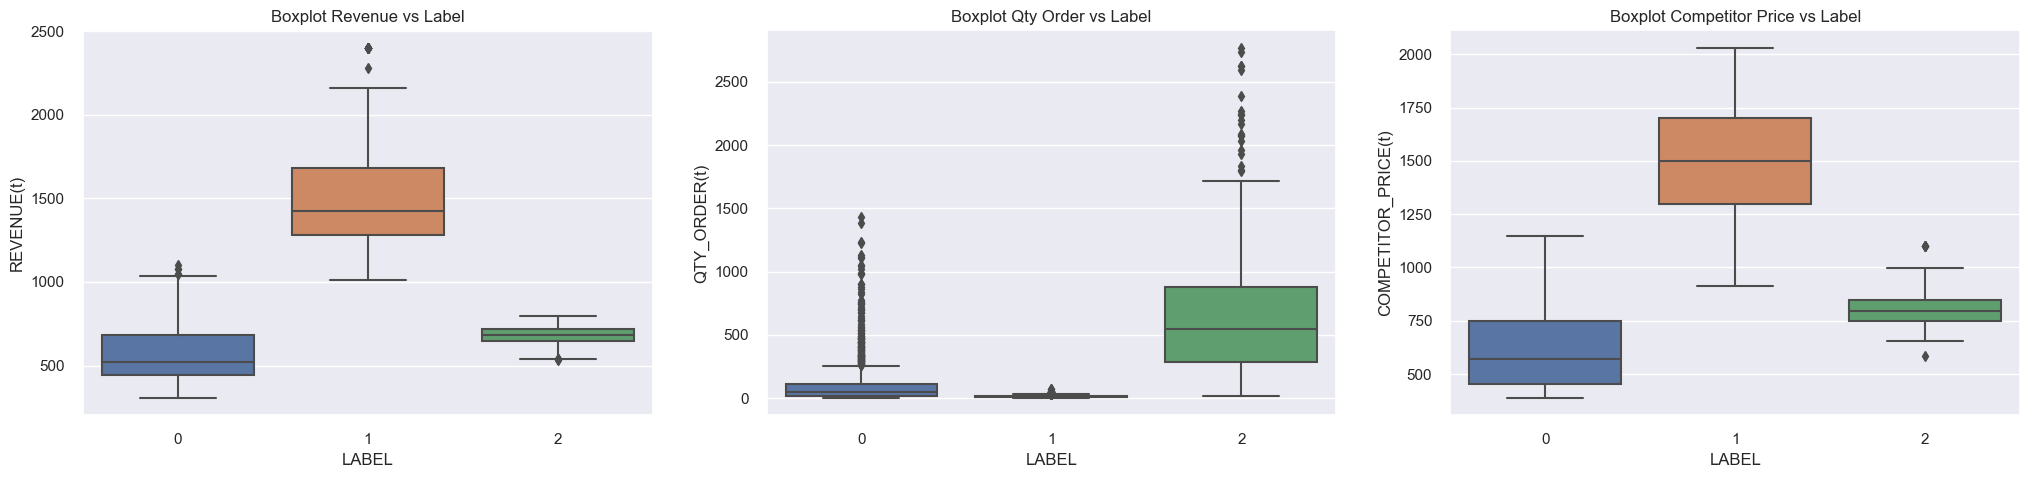

In [978]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

sns.boxplot(data=df_transformed, x='LABEL', y='REVENUE(t)', ax=ax[0])
sns.boxplot(data=df_transformed, x='LABEL', y='QTY_ORDER(t)', ax=ax[1])
sns.boxplot(data=df_transformed, x='LABEL', y='COMPETITOR_PRICE(t)', ax=ax[2])

ax[0].set_title("Boxplot Revenue vs Label")
ax[1].set_title("Boxplot Qty Order vs Label")
ax[2].set_title("Boxplot Competitor Price vs Label")


plt.show()

# Predição do Modelo

## Regressão Linear

In [961]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

0.7610057805406638
0.6391073332956181


### Validação dos resultados

R2 Score Train:  0.7367646465945464
R2 Score Test:  0.724773275753936


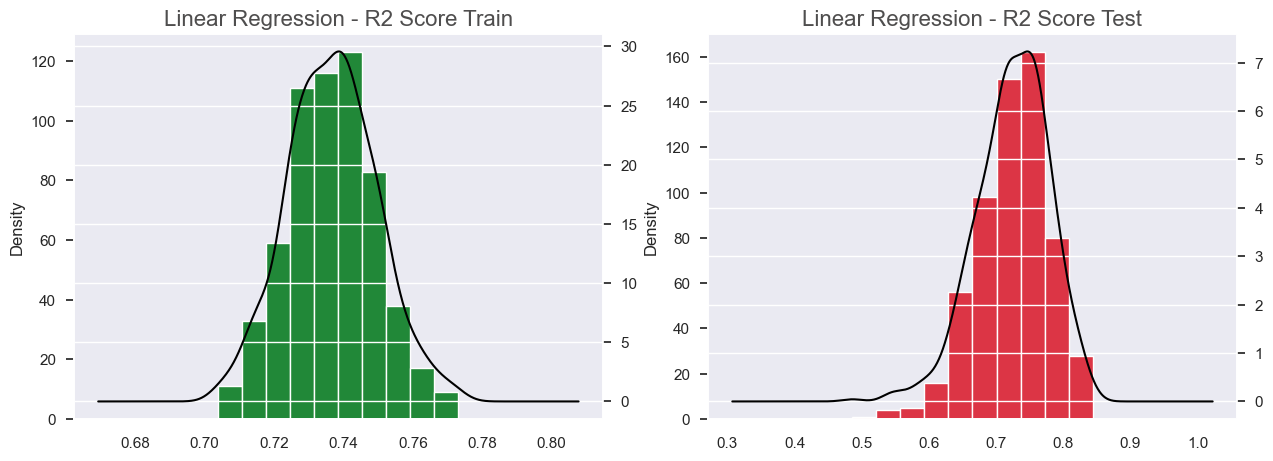

In [962]:
model_report = pd.DataFrame()
predict_traning = []

for exec in range(600):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mdl = {'r2_score_train': r2_score(y_train, y_pred_train), 'r2_score_test': r2_score(y_test, y_pred)}
    predict_traning.append(mdl)

model_report = pd.json_normalize(predict_traning)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set_title("Linear Regression - R2 Score Train", fontsize=16, color='#4f4e4e')
model_report['r2_score_train'].plot.hist(ax=axes[0], color="#218838")
model_report['r2_score_train'].plot(kind='kde', ax=axes[0], secondary_y=True, color='black')

axes[1].set_title("Linear Regression - R2 Score Test", fontsize=16, color='#4f4e4e')
model_report['r2_score_test'].plot.hist(ax=axes[1], color="#dc3545")
model_report['r2_score_test'].plot(kind='kde', ax=axes[1], secondary_y=True, color='black')

print("R2 Score Train: ", model_report['r2_score_train'].mean())
print("R2 Score Test: ", model_report['r2_score_test'].mean())
plt.show()

## Por produto

In [963]:
for i in range(len(prod_mapping)):
    model = LinearRegression()
    model.fit(X_trainp[i], y_trainp[i])
    y_predp = model.predict(X_testp[i])
    y_pred_trainp = model.predict(X_trainp[i])
    print("R2 Score Train ",prod_mapping[i], ": ", r2_score(y_trainp[i], y_pred_trainp))
    print("R2 Score Test ",prod_mapping[i], ": ", r2_score(y_testp[i], y_predp))
    print("--------------")

R2 Score Train  P1 :  0.5153936894113917
R2 Score Test  P1 :  0.4905212214586935
--------------
R2 Score Train  P2 :  0.7124384733731991
R2 Score Test  P2 :  0.36490851336293895
--------------
R2 Score Train  P3 :  0.5999976788921868
R2 Score Test  P3 :  0.4983165917908766
--------------
R2 Score Train  P4 :  0.6349793188022704
R2 Score Test  P4 :  0.6306448240860396
--------------
R2 Score Train  P5 :  0.7326364632451363
R2 Score Test  P5 :  0.6623005461100954
--------------
R2 Score Train  P6 :  0.36461823956714445
R2 Score Test  P6 :  0.27804417868310627
--------------
R2 Score Train  P7 :  0.6084939608617058
R2 Score Test  P7 :  0.44796094801145747
--------------
R2 Score Train  P8 :  0.5325122315429038
R2 Score Test  P8 :  0.603745081240043
--------------
R2 Score Train  P9 :  0.6034433690793135
R2 Score Test  P9 :  0.45315489219982197
--------------


### Regression linear with K-means

In [964]:
for i in range(len(cluster_mapping)):
    model = LinearRegression()
    model.fit(X_traincls[i], y_traincls[i])
    y_predcls = model.predict(X_testcls[i])
    y_pred_traincls = model.predict(X_traincls[i])
    print("R2 Score Train cluster ",cluster_mapping[i], ": ", r2_score(y_traincls[i], y_pred_traincls))
    print("R2 Score Test cluster ",cluster_mapping[i], ": ", r2_score(y_testcls[i], y_predcls))
    print("--------------")

R2 Score Train cluster  1 :  0.4825133732871354
R2 Score Test cluster  1 :  0.569863782873214
--------------
R2 Score Train cluster  0 :  0.6244657490943981
R2 Score Test cluster  0 :  0.6923407445912777
--------------
R2 Score Train cluster  2 :  0.6224700901337175
R2 Score Test cluster  2 :  0.39588864032686355
--------------


## XGBoost

In [965]:
model = XGBRegressor(max_depth=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

0.7915943989789767
0.7328535055802625


### Validação dos resultados

R2 Score Train:  0.7943997931627552
R2 Score Test:  0.7018544133704196


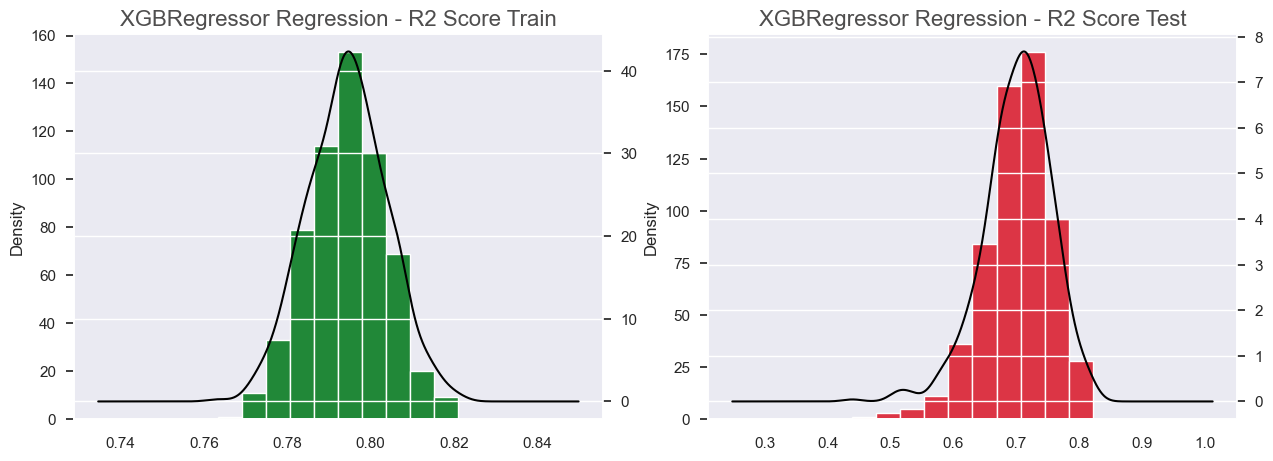

In [966]:
model_report = pd.DataFrame()
predict_traning = []

for exec in range(600):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    model = XGBRegressor(max_depth=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mdl = {'r2_score_train': r2_score(y_train, y_pred_train), 'r2_score_test': r2_score(y_test, y_pred)}
    predict_traning.append(mdl)

model_report = pd.json_normalize(predict_traning)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set_title("XGBRegressor Regression - R2 Score Train", fontsize=16, color='#4f4e4e')
model_report['r2_score_train'].plot.hist(ax=axes[0], color="#218838")
model_report['r2_score_train'].plot(kind='kde', ax=axes[0], secondary_y=True, color='black')

axes[1].set_title("XGBRegressor Regression - R2 Score Test", fontsize=16, color='#4f4e4e')
model_report['r2_score_test'].plot.hist(ax=axes[1], color="#dc3545")
model_report['r2_score_test'].plot(kind='kde', ax=axes[1], secondary_y=True, color='black')

print("R2 Score Train: ", model_report['r2_score_train'].mean())
print("R2 Score Test: ", model_report['r2_score_test'].mean())
plt.show()

### Por produto

In [967]:
for i in range(len(prod_mapping)):
    model = XGBRegressor(max_depth=1)
    model.fit(X_trainp[i], y_trainp[i])
    y_predp = model.predict(X_testp[i])
    y_pred_trainp = model.predict(X_trainp[i])
    print("R2 Score Train ",prod_mapping[i], ": ", r2_score(y_trainp[i], y_pred_trainp))
    print("R2 Score Test ",prod_mapping[i], ": ", r2_score(y_testp[i], y_predp))
    print("--------------")

R2 Score Train  P1 :  0.7022807233090491
R2 Score Test  P1 :  0.30401739349819024
--------------
R2 Score Train  P2 :  0.8510149482323711
R2 Score Test  P2 :  0.1467277759589114
--------------
R2 Score Train  P3 :  0.7898421277850757
R2 Score Test  P3 :  0.4699120576361777
--------------
R2 Score Train  P4 :  0.8744323331466759
R2 Score Test  P4 :  0.6361474100911207
--------------
R2 Score Train  P5 :  0.9584703967613752
R2 Score Test  P5 :  0.6137583146796035
--------------
R2 Score Train  P6 :  0.6180403347568352
R2 Score Test  P6 :  0.22129535441166326
--------------
R2 Score Train  P7 :  0.7553092939130996
R2 Score Test  P7 :  0.2600601204384704
--------------
R2 Score Train  P8 :  0.8821127838863717
R2 Score Test  P8 :  0.46068485308804863
--------------
R2 Score Train  P9 :  0.9209716371604715
R2 Score Test  P9 :  0.46413960401708987
--------------


### Xgboost with K-means

In [968]:
for i in range(len(cluster_mapping)):
    model = XGBRegressor(max_depth=1)
    model.fit(X_traincls[i], y_traincls[i])
    y_predcls = model.predict(X_testcls[i])
    y_pred_traincls = model.predict(X_traincls[i])
    print("R2 Score Train cluster ",cluster_mapping[i], ": ", r2_score(y_traincls[i], y_pred_traincls))
    print("R2 Score Test cluster ",cluster_mapping[i], ": ", r2_score(y_testcls[i], y_predcls))
    print("--------------")

R2 Score Train cluster  1 :  0.5821968020182677
R2 Score Test cluster  1 :  0.5388763084497287
--------------
R2 Score Train cluster  0 :  0.7220012835593224
R2 Score Test cluster  0 :  0.5728706723673512
--------------
R2 Score Train cluster  2 :  0.7675118899326681
R2 Score Test cluster  2 :  0.24873653523115447
--------------


# Validação dos resultados

In [969]:
for i in range(len(prod_mapping)):
    model = LinearRegression()
    model.fit(X_trainp[i], y_trainp[i])
    y_predp = model.predict(X_testp[i])
    y_pred_trainp = model.predict(X_trainp[i])
    print("R2 Score Train ",prod_mapping[i], ": ", r2_score(y_trainp[i], y_pred_trainp))
    print("R2 Score Test ",prod_mapping[i], ": ", r2_score(y_testp[i], y_predp))
    print("--------------")

R2 Score Train  P1 :  0.5153936894113917
R2 Score Test  P1 :  0.4905212214586935
--------------
R2 Score Train  P2 :  0.7124384733731991
R2 Score Test  P2 :  0.36490851336293895
--------------
R2 Score Train  P3 :  0.5999976788921868
R2 Score Test  P3 :  0.4983165917908766
--------------
R2 Score Train  P4 :  0.6349793188022704
R2 Score Test  P4 :  0.6306448240860396
--------------
R2 Score Train  P5 :  0.7326364632451363
R2 Score Test  P5 :  0.6623005461100954
--------------
R2 Score Train  P6 :  0.36461823956714445
R2 Score Test  P6 :  0.27804417868310627
--------------
R2 Score Train  P7 :  0.6084939608617058
R2 Score Test  P7 :  0.44796094801145747
--------------
R2 Score Train  P8 :  0.5325122315429038
R2 Score Test  P8 :  0.603745081240043
--------------
R2 Score Train  P9 :  0.6034433690793135
R2 Score Test  P9 :  0.45315489219982197
--------------


In [970]:
# lr_prod = []
# lr_clus = []

# xg_prod = []
# xg_clus = []

# for exec in range(600):
#     base = 'LABEL'
#     X_traincls, X_testcls, y_traincls, y_testcls = [], [], [], []
#     cluster_mapping = {}
#     c=0
#     for b in df_transformed[base].unique():
#         Xp = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID", 'LABEL']).loc[df_transformed[base] == b]
#         yp = df_transformed["QTY_ORDER(t)"].loc[df_transformed[base] == b]
        
#         X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(Xp, yp, test_size=.2)

#         X_traincls.append(X_train_cls)
#         X_testcls.append(X_test_cls)
#         y_traincls.append(y_train_cls)
#         y_testcls.append(y_test_cls)

#         cluster_mapping[c] = b
#         c+=1

#     base = 'PROD_ID'
#     X_trainp, X_testp, y_trainp, y_testp = [], [], [], []
#     prod_mapping = {}
#     c=0
#     for b in df[base].unique():
#         Xcls = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"]).loc[df_transformed[base] == b]
#         ycls = df_transformed["QTY_ORDER(t)"].loc[df_transformed[base] == b]
        
#         X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xcls, ycls, test_size=.2)
        
#         X_trainp.append(X_train_t)
#         X_testp.append(X_test_t)
#         y_trainp.append(y_train_t)
#         y_testp.append(y_test_t)

#         prod_mapping[c] = b
#         c+=1


#     for i in range(len(prod_mapping)):
#         model = LinearRegression()
#         model.fit(X_trainp[i], y_trainp[i])
#         y_predp = model.predict(X_testp[i])
#         y_pred_trainp = model.predict(X_trainp[i])

#         mdl = {'r2_score_train_'+str(prod_mapping[i]): r2_score(y_trainp[i], y_pred_trainp),
#             'r2_score_test_'+str(prod_mapping[i]): r2_score(y_testp[i], y_predp)}
#         lr_prod.append(mdl)

#     for i in range(len(cluster_mapping)):
#         model = LinearRegression()
#         model.fit(X_traincls[i], y_traincls[i])
#         y_predcls = model.predict(X_testcls[i])
#         y_pred_traincls = model.predict(X_traincls[i])

#         mdl = {'r2_score_train_'+str(cluster_mapping[i]): r2_score(y_traincls[i], y_pred_traincls), 
#             'r2_score_test_'+str(cluster_mapping[i]): r2_score(y_testcls[i], y_predcls)}
#         lr_clus.append(mdl)


#     for i in range(len(prod_mapping)):
#         model = XGBRegressor(max_depth=1)
#         model.fit(X_trainp[i], y_trainp[i])
#         y_predp = model.predict(X_testp[i])
#         y_pred_trainp = model.predict(X_trainp[i])

#         mdl = {'r2_score_train_'+str(prod_mapping[i]): r2_score(y_trainp[i], y_pred_trainp),
#             'r2_score_test_'+str(prod_mapping[i]): r2_score(y_testp[i], y_predp)}
#         xg_prod.append(mdl)

#     for i in range(len(cluster_mapping)):
#         model = XGBRegressor(max_depth=1)
#         model.fit(X_traincls[i], y_traincls[i])
#         y_predcls = model.predict(X_testcls[i])
#         y_pred_traincls = model.predict(X_traincls[i])

#         mdl = {'r2_score_train_'+str(cluster_mapping[i]): r2_score(y_traincls[i], y_pred_traincls), 
#             'r2_score_test_'+str(cluster_mapping[i]): r2_score(y_testcls[i], y_predcls)}
#         xg_clus.append(mdl)

In [972]:
lr_prod_model_report = pd.json_normalize(lr_prod)
lr_clus_model_report = pd.json_normalize(lr_clus)
xg_prod_model_report = pd.json_normalize(xg_prod)
xg_clus_model_report = pd.json_normalize(xg_clus)

lr_prod_model_report= pd.read_csv('lr_prod_model_report.csv')
lr_clus_model_report= pd.read_csv('lr_clus_model_report.csv')
xg_prod_model_report= pd.read_csv('xg_prod_model_report.csv')
xg_clus_model_report= pd.read_csv('xg_clus_model_report.csv')

lr_prod_model_report.to_csv('lr_prod_model_report.csv', index=False)
lr_clus_model_report.to_csv('lr_clus_model_report.csv', index=False)
xg_prod_model_report.to_csv('xg_prod_model_report.csv', index=False)
xg_clus_model_report.to_csv('xg_clus_model_report.csv', index=False)

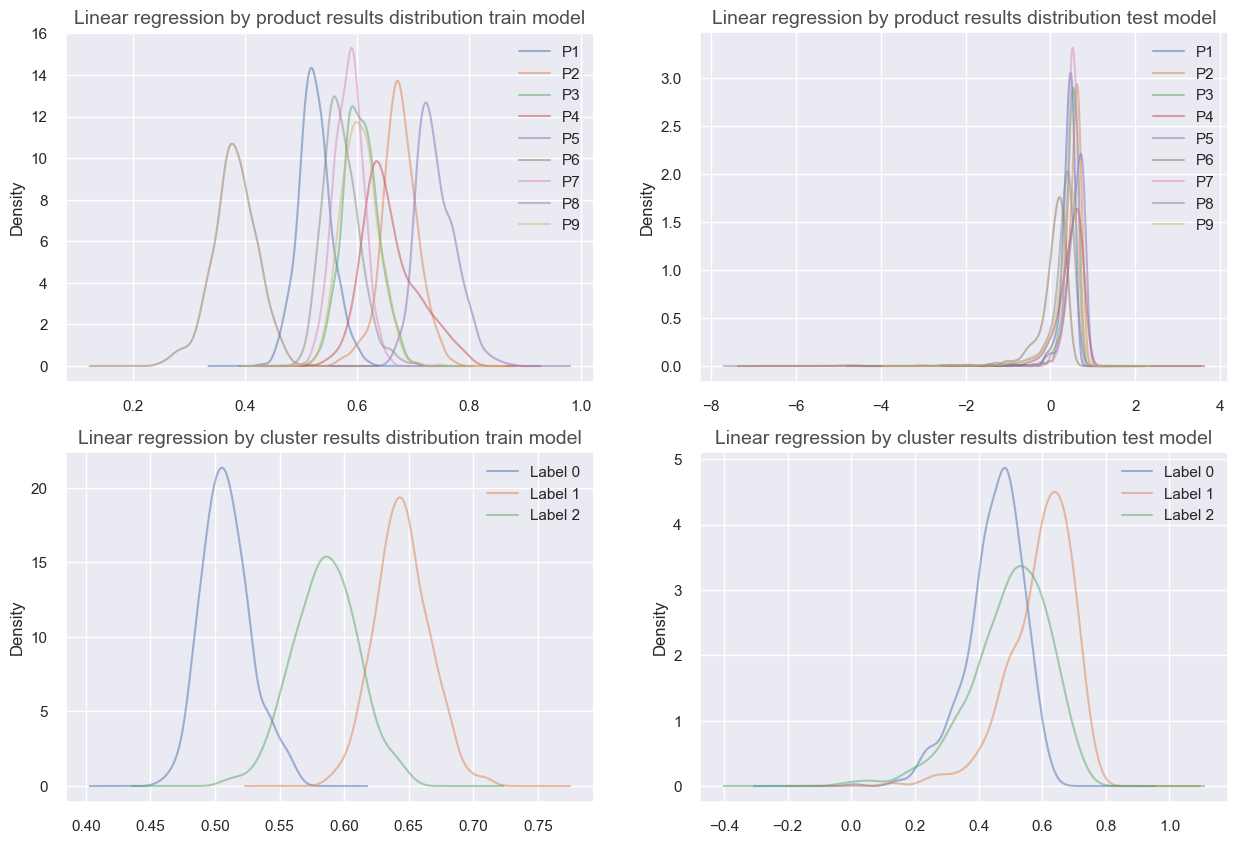

In [992]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

lr_prod_md_report = pd.DataFrame({
    'P1': lr_prod_model_report['r2_score_train_P1'].dropna(),
    'P2': lr_prod_model_report['r2_score_train_P2'].dropna(),
    'P3': lr_prod_model_report['r2_score_train_P3'].dropna(),
    'P4': lr_prod_model_report['r2_score_train_P4'].dropna(),
    'P5': lr_prod_model_report['r2_score_train_P5'].dropna(),
    'P6': lr_prod_model_report['r2_score_train_P6'].dropna(),
    'P7': lr_prod_model_report['r2_score_train_P7'].dropna(),
    'P8': lr_prod_model_report['r2_score_train_P8'].dropna(),
    'P9': lr_prod_model_report['r2_score_train_P9'].dropna(),
})

lr_prod_md_report.plot.kde(ax=axes[0][0], alpha=0.5)

axes[0][0].set_title("Linear regression by product results distribution train model", fontsize=14, color='#4f4e4e')

lr_prod_md_report = pd.DataFrame({
    'P1': lr_prod_model_report['r2_score_test_P1'].dropna(),
    'P2': lr_prod_model_report['r2_score_test_P2'].dropna(),
    'P3': lr_prod_model_report['r2_score_test_P3'].dropna(),
    'P4': lr_prod_model_report['r2_score_test_P4'].dropna(),
    'P5': lr_prod_model_report['r2_score_test_P5'].dropna(),
    'P6': lr_prod_model_report['r2_score_test_P6'].dropna(),
    'P7': lr_prod_model_report['r2_score_test_P7'].dropna(),
    'P8': lr_prod_model_report['r2_score_test_P8'].dropna(),
    'P9': lr_prod_model_report['r2_score_test_P9'].dropna(),
})

lr_prod_md_report.plot.kde(ax=axes[0][1], alpha=0.5)

axes[0][1].set_title("Linear regression by product results distribution test model", fontsize=14, color='#4f4e4e')

lr_clus_md_report = pd.DataFrame({
    'Label 0': lr_clus_model_report['r2_score_train_0'].dropna(),
    'Label 1': lr_clus_model_report['r2_score_train_1'].dropna(),
    'Label 2': lr_clus_model_report['r2_score_train_2'].dropna(),
})

lr_clus_md_report.plot.kde(ax=axes[1][0], alpha=0.5)

axes[1][0].set_title("Linear regression by cluster results distribution train model", fontsize=14, color='#4f4e4e')

lr_clus_md_report = pd.DataFrame({
    'Label 0': lr_clus_model_report['r2_score_test_0'].dropna(),
    'Label 1': lr_clus_model_report['r2_score_test_1'].dropna(),
    'Label 2': lr_clus_model_report['r2_score_test_2'].dropna(),

})

lr_clus_md_report.plot.kde(ax=axes[1][1], alpha=0.5)

axes[1][1].set_title("Linear regression by cluster results distribution test model", fontsize=14, color='#4f4e4e')

plt.show()

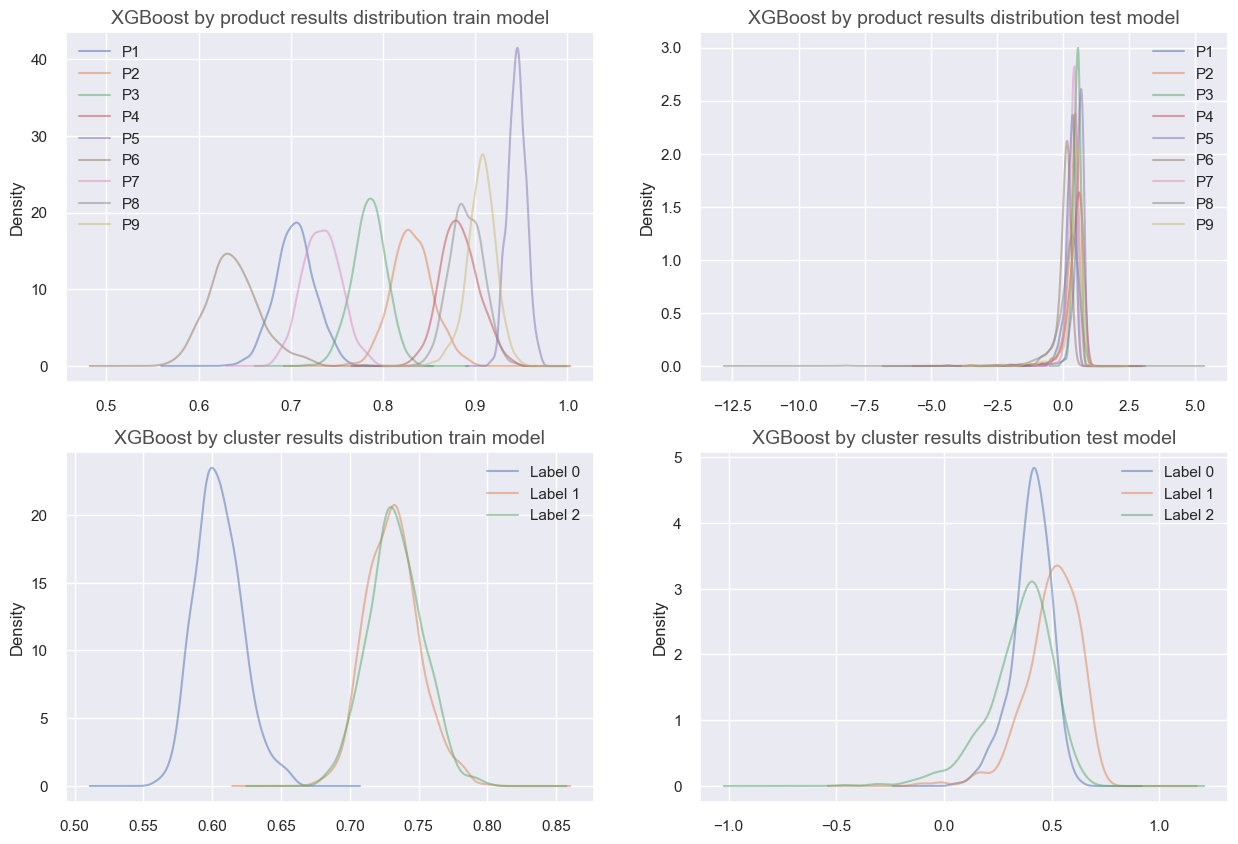

In [997]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

xg_prod_md_report = pd.DataFrame({
    'P1': xg_prod_model_report['r2_score_train_P1'].dropna(),
    'P2': xg_prod_model_report['r2_score_train_P2'].dropna(),
    'P3': xg_prod_model_report['r2_score_train_P3'].dropna(),
    'P4': xg_prod_model_report['r2_score_train_P4'].dropna(),
    'P5': xg_prod_model_report['r2_score_train_P5'].dropna(),
    'P6': xg_prod_model_report['r2_score_train_P6'].dropna(),
    'P7': xg_prod_model_report['r2_score_train_P7'].dropna(),
    'P8': xg_prod_model_report['r2_score_train_P8'].dropna(),
    'P9': xg_prod_model_report['r2_score_train_P9'].dropna(),
})

xg_prod_md_report.plot.kde(ax=axes[0][0], alpha=0.5)

axes[0][0].set_title("XGBoost by product results distribution train model", fontsize=14, color='#4f4e4e')

xg_prod_md_report = pd.DataFrame({
    'P1': xg_prod_model_report['r2_score_test_P1'].dropna(),
    'P2': xg_prod_model_report['r2_score_test_P2'].dropna(),
    'P3': xg_prod_model_report['r2_score_test_P3'].dropna(),
    'P4': xg_prod_model_report['r2_score_test_P4'].dropna(),
    'P5': xg_prod_model_report['r2_score_test_P5'].dropna(),
    'P6': xg_prod_model_report['r2_score_test_P6'].dropna(),
    'P7': xg_prod_model_report['r2_score_test_P7'].dropna(),
    'P8': xg_prod_model_report['r2_score_test_P8'].dropna(),
    'P9': xg_prod_model_report['r2_score_test_P9'].dropna(),
})

xg_prod_md_report.plot.kde(ax=axes[0][1], alpha=0.5)

axes[0][1].set_title("XGBoost by product results distribution test model", fontsize=14, color='#4f4e4e')

xg_clus_md_report = pd.DataFrame({
    'Label 0': xg_clus_model_report['r2_score_train_0'].dropna(),
    'Label 1': xg_clus_model_report['r2_score_train_1'].dropna(),
    'Label 2': xg_clus_model_report['r2_score_train_2'].dropna(),
})

xg_clus_md_report.plot.kde(ax=axes[1][0], alpha=0.5)

axes[1][0].set_title("XGBoost by cluster results distribution train model", fontsize=14, color='#4f4e4e')

xg_clus_md_report = pd.DataFrame({
    'Label 0': xg_clus_model_report['r2_score_test_0'].dropna(),
    'Label 1': xg_clus_model_report['r2_score_test_1'].dropna(),
    'Label 2': xg_clus_model_report['r2_score_test_2'].dropna(),

})

xg_clus_md_report.plot.kde(ax=axes[1][1], alpha=0.5)

axes[1][1].set_title("XGBoost by cluster results distribution test model", fontsize=14, color='#4f4e4e')

plt.show()